In [1]:
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline

#Astropy 
from astropy.utils.data import download_file
from astropy.io import fits
import astropy.units as u
from astropy.utils import data
from astropy.wcs import WCS

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from spectral_cube import SpectralCube
from reproject import reproject_interp

Created TAP+ (v20200428.1) - Connection:
	Host: sky.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

In [3]:
file = fits.open(image_file)
file.info()

Filename: C:\Users\salam\.astropy\cache\download\py3\2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


In [4]:
image_data = fits.getdata(image_file)
#file = fits.open(image_file)
#image_data = file[0].data

In [5]:
image_data.shape

(893, 891)

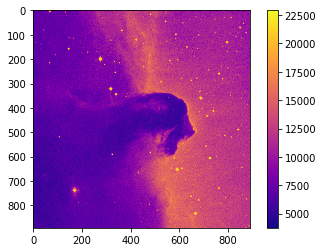

In [6]:
plt.imshow(image_data, cmap='plasma')
plt.colorbar()

In [7]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.481676287574
Stdev: 3032.3927542049046


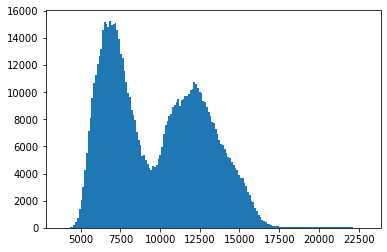

In [8]:
histogram = plt.hist(image_data.flatten(), bins='auto')

[Text(1, 0, '5,000'), Text(1, 0, '10,000'), Text(1, 0, '20,000')]

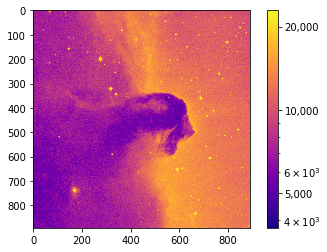

In [9]:
plt.imshow(image_data, cmap='plasma', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

 ## Image stacking

In [10]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = [download_file(base_url.format(n), cache=True) for n in range(1, 5+1)]
image_concat = [fits.getdata(image) for image in image_list]

In [11]:
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image
# final_image = np.sum(image_concat, axis=0)

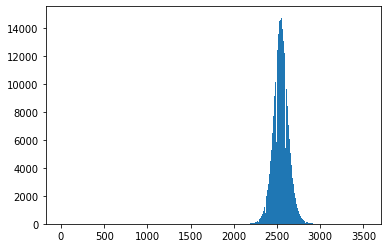

In [12]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

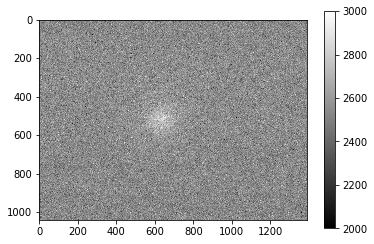

In [13]:
plt.imshow(final_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

In [14]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

# Magellanic Clouds

In [15]:
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
    cache=True, show_progress=True)

In [16]:
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

In [17]:
print(cube)

SpectralCube with shape=(450, 150, 150) and unit=K:
 n_x:    150  type_x: GLON-TAN  unit_x: deg    range:   286.727203 deg:  320.797623 deg
 n_y:    150  type_y: GLAT-TAN  unit_y: deg    range:   -50.336450 deg:  -28.401234 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


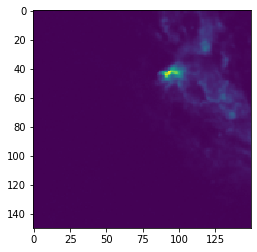

In [18]:
cube[300, :, :].quicklook()

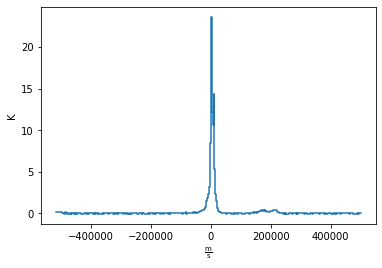

In [19]:
cube[:, 75, 75].quicklook()

In [20]:
_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [21]:
# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

print(sub_cube)

SpectralCube with shape=(450, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


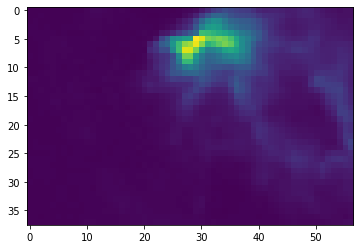

In [22]:
sub_cube[300, :, :].quicklook()

In [23]:
sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
print(sub_cube_slab) #Cut along the Spectral Axis

SpectralCube with shape=(226, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    226  type_s: VRAD      unit_s: m / s  range:  -299683.842 m / s:  301268.441 m / s


### moment map

In [25]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

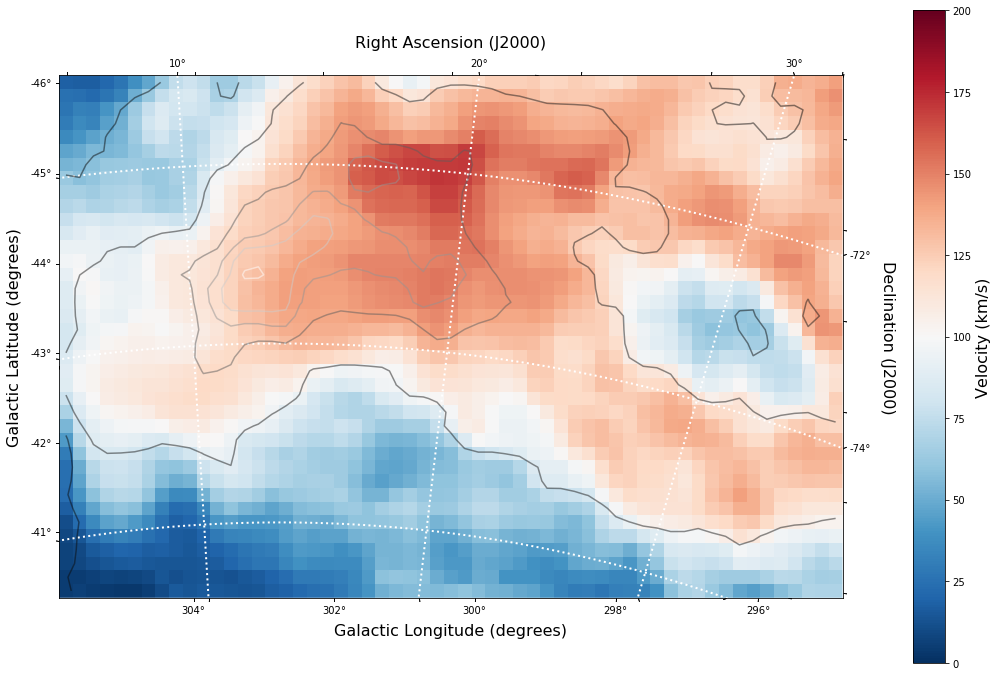

In [26]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
# Add an Axes to the figure as part of a subplot arrangement.
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

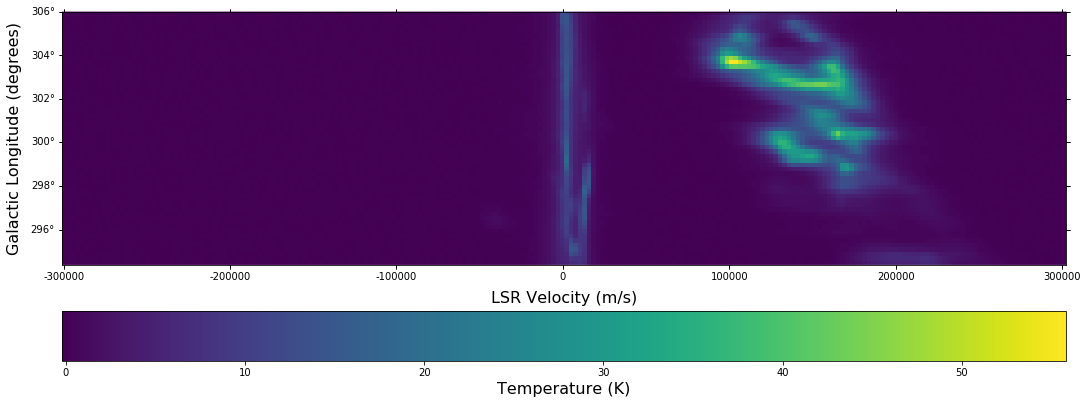

In [27]:
lat_slice = 18  # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick only the lat_slice
# indicated, and plot the velocity along the x axis

# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)  # Display the image slice
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Temperature (K)', size=16)

# Herschel Image

In [9]:
result = ESASky.query_region_maps('SMC', radius=1*u.deg, missions='Herschel')

print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 15 column(s) and 28 row(s) 


In [11]:
result['HERSCHEL']['filter']

"70, 160"
"250, 350, 500"
"100, 160"
"70, 160"
"70, 160"
"70, 160"
"70, 160"
"250, 350, 500"
"100, 160"
"70, 160"
"70, 160"
